<center> <H1> Integrated Intensity Comparison between MRGs before and after fusion </H1> </center>

                        *Code written by Timo Rey. Laboratory of Experimental Biophysics, EPFL*
                                            *Created 2019 - 20*

#### Aims:
    Test whether mitochondrial RNA granules loose material upon fusion.
#### H0:
    Fused MRGs are composed of the sum of both pre-fusion MRGs. 
#### Approach:
    1) Approximate the amount of molecules within each granule before fusion by measuring its integrated intensity (intint).
    2) Determine the expected value after fusion as the sum of the intint of all granules that will fuse
    3) Measure the intint of the granule after fusion.
    4) Compare measured to expected balue

In [1]:
# libraries:
from pathlib import Path
import pandas as pd
from glob import glob
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
directory   = Path('C:/Users/Public/Documents/01_Fusion/IntegratedIntensity/Timepoints/')   # specify the path to the input data
outDir      = 'C:/Users/Public/Documents/01_Fusion/IntegratedIntensity/Output/'

In [3]:
# Define functions:

def FindDirs():
    all_folders = directory.glob('*')                                # find files with specific ending
    dirList = sorted(all_folders)                                    # because 'generator object' (.glob) is not a list  
    return dirList

def FindData(Folder, extension):
    all_csv = Folder.glob('**/*' + extension + '*.csv')              # find files with specific ending
    csvList = sorted(all_csv)                                        # because 'generator object' (.glob) is not a list  
    return csvList

def OpenCsvFromList(csvList, Parser):                                # input = list of files to open + position of file in list 
    with open(str(csvList[Parser]), 'r') as file:
        df = pd.read_csv(file, sep = ',')
    return df

def CombineData(csvList):
    Parser = 0                                                        # can change if do not want to start with first file
    Combined_df = pd.DataFrame()                                      # to initiate a df that can be appended to
    
    while Parser < len(csvList):
        next_df = OpenCsvFromList(csvList, Parser)
        Combined_df = pd.concat([Combined_df, next_df], ignore_index = True)
        Parser += 1
    return Combined_df


def AnalyseTimepoint(Granule):
    # find background level
    Bckgrd = Granule["Mean"][Granule["Type"]=="Background"]
    
    # find only granules
    Grains = Granule[Granule["Type"]=="Granule"]

    # correct raw integrated intensities by background subtraction
    Grains["CorrIntDen"] = Grains["IntDen"] - Grains["Area"] * float(Bckgrd)
    
    if len(Grains) > 1:
        Type = 'before'
    elif len(Grains) == 1:
        Type = 'after'
    Grains["Type"] = Type
    
    return Grains

In [4]:
# Find all folders (FOVs):
ListDirs = FindDirs()

# For each FOV:
for i in ListDirs:
    # find all results tables (for each time-point)
    FOVname = os.path.basename(i)
    #print("starting with " + FOVname)
    Data    = FindData(i, "Results")
    
    # for each time-point:
    Parser  = 0
    FOV_df  = pd.DataFrame()
    
    while Parser < len(Data):
        # open:
        df = OpenCsvFromList(Data, Parser)
        # extract & calculate relevant values for all granule (per time-point):
        TimePt_df = AnalyseTimepoint(df)
        FOV_df = pd.concat([FOV_df, TimePt_df], ignore_index = True)
        Parser += 1

    # make a new dataframe and copy & compute relevant information 
    OneFOV = pd.DataFrame()
    
    OneFOV["TimeScale"] = FOV_df["TimeScale"]
    OneFOV["FOV"] = FOVname
    
    # normalise against average-sum of pre-fusion granules.
    Sum       = FOV_df["CorrIntDen"][FOV_df["Type"] == 'before'].sum()        # summed intensity of all pre-fusion timepoints
    numbr     = np.asarray(FOV_df["Timepoint"][FOV_df["Type"] == 'before'])   # array of pre-fusion timepoints
    numtimPts = len(np.unique(numbr))                                         # number of pre-fusion timepoints
    avgSum = Sum / numtimPts                                                  # total-sum / numbr-timepts = average
    OneFOV["Expected"] = avgSum                                               # expected = this average.
    
    # for each time-point:
    OneFOV["Label"] = FOV_df["Label"]
    OneFOV["TimePoint"] = FOV_df["Timepoint"]
    
    # for each granule:
    OneFOV["Type"] = FOV_df["Type"]
    OneFOV["Area"] = FOV_df["Area"]
    OneFOV["CorrIntDen"] = FOV_df["CorrIntDen"]
    OneFOV["NormIntDen"] = FOV_df["CorrIntDen"] / OneFOV["Expected"]

    #print("done with that.")
    
    OneFOV.to_csv(outDir + FOVname + "_Results.csv")

C:\Users\threy\miniconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\threy\miniconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
# combine all FOVs into 1 file
All_FOVs = CombineData(FindData(Path(outDir), "_Results"))
All_FOVs.drop_duplicates()
All_FOVs = All_FOVs.drop(['Unnamed: 0'], axis = 1)
All_FOVs.to_csv(outDir + "oneResult.csv")
len(All_FOVs["FOV"])

133

### make plot:

In [6]:
# Note: need to manually rank the Results.

In [7]:
file = outDir + "oneResult_ranked.csv"
df   = pd.read_csv(file, sep = ',')
df = df.drop(['Unnamed: 0'], axis = 1)

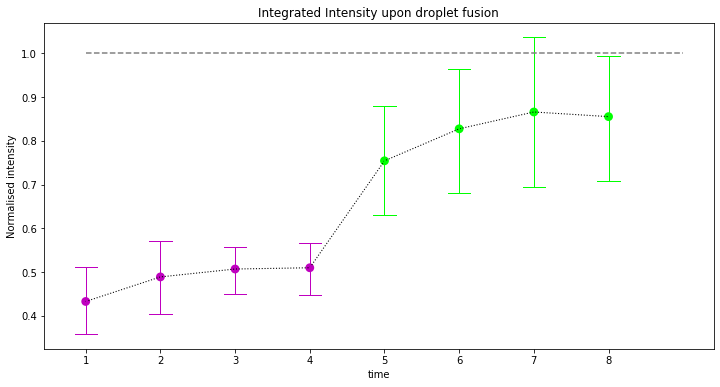

In [8]:
f,ax = plt.subplots(figsize = (12,6))
sns.pointplot(x="Rank", y="NormIntDen", data=df, linestyles='dotted', scale=0.4, color='k', errwidth=0, capsize=0)
sns.pointplot(x="Rank", y="NormIntDen", data=df, linestyles='', scale=1, palette = ['m', 'm', 'm', 'm', 'lime', 'lime', 'lime', 'lime'], errwidth=1, capsize=0.3)
plt.plot(np.linspace(0,8,8), np.linspace(1,1,8), '--', color = 'gray')
plt.xlabel("time")
plt.ylabel("Normalised intensity")
plt.title("Integrated Intensity upon droplet fusion");
plt.savefig(outDir+'IntegratedIntensity_Time.svg')